# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes



config = {
    'function_family': {
        'maximum_depth': 4,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,                      
    },
    'data': {
        'number_of_variables': 5, 
        'num_classes': 2,
        
        'function_generation_type': 'random_decision_tree', # 'make_classification' 'random_decision_tree'
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 1000, #number of samples per function
        #'number_of_generated_datasets': 10000,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-2,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [64],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
        
        'number_of_lambda_weights': None,
        
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 10000,
    },     
    
    'i_net': {
        'dense_layers': [1056, 512],
        'convolution_layers': None,
        'lstm_layers': None,
        'dropout': [0.2, 0.1],
        
        'optimizer': 'adam', #adam
        'learning_rate': 0.001,
        'loss': 'binary_crossentropy',
        'metrics': ['binary_accuracy'],
        
        'epochs': 10, 
        'early_stopping': True,
        'batch_size': 256,

        'interpretation_dataset_size': 500,
                
        'test_size': 50, #Float for fraction, Int for number 0
        
        'function_representation_type': 3, # 1=standard representation; 2=sparse representation, 3=vanilla_dt

        'optimize_decision_function': True, #False
        'function_value_loss': True, #False
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },    
    
    'evaluation': {   
        #'inet_holdout_seed_evaluation': False,
            
        'random_evaluation_dataset_size': 50, 
        'per_network_optimization_dataset_size': 5000,

        'sklearn_dt_benchmark': False,
        'sdt_benchmark': False,
        
    },    
    
    'computation':{
        'load_model': False,
        
        'n_jobs': -3,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}


## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import tensorflow as tf
import tensorflow_addons as tfa
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns


import random 


import warnings

from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output



In [4]:
tf.__version__

'2.4.1'

In [5]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [6]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################

config['i_net']['data_reshape_version'] = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/lib/cuda-10.1'

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)

warnings.filterwarnings('ignore')

In [7]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
from utilities.DecisionTree_BASIC import *

#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
config['function_family']['basic_function_representation_length'] = (2 ** maximum_depth - 1) * number_of_variables + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes
config['function_family']['function_representation_length'] = ( (2 ** maximum_depth - 1) * number_of_variables + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes  if function_representation_type == 1 
                                                              else (2 ** maximum_depth - 1) * decision_sparsity + (2 ** maximum_depth - 1) + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) * num_classes if function_representation_type == 2
                                                              else (2 ** maximum_depth - 1) * decision_sparsity + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) * num_classes)

#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)
#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='interpretation_net'))
create_folders_inet(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [8]:
print(path_identifier_interpretation_net)

print(path_identifier_lambda_net_data)


lNetSize1000_numLNets10000_var5_class2_random_decision_tree_xMax1_xMin0_xDistuniform_depth4_beta1_decisionSpars1_fullyGrown/64_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42/inet_dense1056-512_drop0.2-0.1e10b256_adam
lNetSize1000_numLNets10000_var5_class2_random_decision_tree_xMax1_xMin0_xDistuniform_depth4_beta1_decisionSpars1_fullyGrown/64_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42


In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(config, no_noise=False, n_jobs=1):
    
    #def generate_lambda_net()
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    if no_noise==True:
        config['noise_injected_level'] = 0
    path_dict = generate_paths(config, path_type='interpretation_net')        
        
    directory = './data/weights/' + 'weights_' + path_dict['path_identifier_lambda_net_data'] + '/'
    path_network_parameters = directory + 'weights' + '.txt'
    path_X_data = directory + 'X_test_lambda.txt'
    path_y_data = directory + 'y_test_lambda.txt'        
    
    network_parameters = pd.read_csv(path_network_parameters, sep=",", header=None)
    network_parameters = network_parameters.sort_values(by=0)
    if no_noise == False:
        network_parameters = network_parameters.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
    
    X_test_lambda = pd.read_csv(path_X_data, sep=",", header=None)
    X_test_lambda = X_test_lambda.sort_values(by=0)
    if no_noise == False:
        X_test_lambda = X_test_lambda.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
    
    y_test_lambda = pd.read_csv(path_y_data, sep=",", header=None)
    y_test_lambda = y_test_lambda.sort_values(by=0)
    if no_noise == False:
        y_test_lambda = y_test_lambda.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
        
        
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky

    lambda_nets = parallel(delayed(LambdaNet)(network_parameters_row, 
                                              X_test_lambda_row, 
                                              y_test_lambda_row, 
                                              config) for network_parameters_row, X_test_lambda_row, y_test_lambda_row in zip(network_parameters.values, X_test_lambda.values, y_test_lambda.values))          
    del parallel
    
    base_model = generate_base_model(config)  
    
    def initialize_network_wrapper(config, lambda_net, base_model):
        lambda_net.initialize_network(config, base_model)
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='sequential')
    _ = parallel(delayed(initialize_network_wrapper)(config, lambda_net, base_model) for lambda_net in lambda_nets)   
    del parallel
    
    def initialize_target_function_wrapper(config, lambda_net):
        lambda_net.initialize_target_function(config)
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='sequential')
    _ = parallel(delayed(initialize_target_function_wrapper)(config, lambda_net) for lambda_net in lambda_nets)   
    del parallel
        
    
    #lambda_nets = [None] * network_parameters.shape[0]
    #for i, (network_parameters_row, X_test_lambda_row, y_test_lambda_row) in tqdm(enumerate(zip(network_parameters.values, X_test_lambda.values, y_test_lambda.values)), total=network_parameters.values.shape[0]):        
    #    lambda_net = LambdaNet(network_parameters_row, X_test_lambda_row, y_test_lambda_row, config)
    #    lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA
if noise_injected_level > 0:
    lambda_net_dataset_training = load_lambda_nets(config, no_noise=True, n_jobs=n_jobs)
    lambda_net_dataset_evaluation = load_lambda_nets(config, n_jobs=n_jobs)

    lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset_training, test_split=0.1)
    _, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset_evaluation, test_split=test_size)
    
else:
    lambda_net_dataset = load_lambda_nets(config, n_jobs=n_jobs)

    lambda_net_dataset_train_with_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
    lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset_train_with_valid, test_split=0.1)

    

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-3)]: Done  84 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-3)]: Done 420 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-3)]: Done 500 out of 500 | elapsed:    8.7s finished
[Parallel(n_jobs=-3)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-3)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-3)]: Done 500 out of 500 | elapsed:   13.6s finished
[Parallel(n_jobs=-3)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-3)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-3)]: Done 500 out of 500 | elapsed:    1.4s finished


## Data Inspection

In [12]:
lambda_net_dataset_train.shape

(405, 573)

In [13]:
lambda_net_dataset_valid.shape

(45, 573)

In [14]:
lambda_net_dataset_test.shape

(50, 573)

In [15]:
lambda_net_dataset_train.as_pandas(config).head()

,index,seed,f0v0,f0v1,f0v2,f0v3,f0v4,f1v0,f1v1,f1v2,f1v3,f1v4,f2v0,f2v1,f2v2,f2v3,f2v4,f3v0,f3v1,f3v2,f3v3,f3v4,f4v0,f4v1,f4v2,f4v3,f4v4,f5v0,f5v1,f5v2,f5v3,f5v4,f6v0,f6v1,f6v2,f6v3,f6v4,f7v0,f7v1,f7v2,f7v3,f7v4,f8v0,f8v1,f8v2,f8v3,f8v4,f9v0,f9v1,f9v2,f9v3,f9v4,f10v0,f10v1,f10v2,f10v3,f10v4,f11v0,f11v1,f11v2,f11v3,f11v4,f12v0,f12v1,f12v2,f12v3,f12v4,f13v0,f13v1,f13v2,f13v3,f13v4,f14v0,f14v1,f14v2,f14v3,f14v4,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,lp0c0,lp0c1,lp1c0,lp1c1,lp2c0,lp2c1,lp3c0,lp3c1,...,wb_349,wb_350,wb_351,wb_352,wb_353,wb_354,wb_355,wb_356,wb_357,wb_358,wb_359,wb_360,wb_361,wb_362,wb_363,wb_364,wb_365,wb_366,wb_367,wb_368,wb_369,wb_370,wb_371,wb_372,wb_373,wb_374,wb_375,wb_376,wb_377,wb_378,wb_379,wb_380,wb_381,wb_382,wb_383,wb_384,wb_385,wb_386,wb_387,wb_388,wb_389,wb_390,wb_391,wb_392,wb_393,wb_394,wb_395,wb_396,wb_397,wb_398,wb_399,wb_400,wb_401,wb_402,wb_403,wb_404,wb_405,wb_406,wb_407,wb_408,wb_409,wb_410,wb_411,wb_412,wb_413,wb_414,wb_415,wb_416,wb_417,wb_418,wb_419,wb_420,wb_421,wb_422,wb_423,wb_424,wb_425,wb_426,wb_427,wb_428,wb_429,wb_430,wb_431,wb_432,wb_433,wb_434,wb_435,wb_436,wb_437,wb_438,wb_439,wb_440,wb_441,wb_442,wb_443,wb_444,wb_445,wb_446,wb_447,wb_448
5885,5885.000,42,0.000,0.000,0.000,0.000,0.404,0.000,-0.419,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.363,0.000,-0.391,0.000,0.000,0.000,0.328,0.000,0.000,0.000,0.000,0.000,0.441,0.000,0.000,0.000,0.000,0.000,0.000,-0.337,0.000,0.348,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.356,0.000,0.000,0.000,0.392,0.000,0.000,0.000,0.000,-0.440,0.000,0.000,0.000,0.411,0.000,0.000,0.000,0.000,0.000,-0.189,0.000,-0.318,0.000,0.000,0.000,0.000,0.000,0.000,-0.349,0.000,0.000,0.307,0.050,-0.357,0.224,-0.298,-0.080,-0.037,0.040,0.287,-0.019,0.217,0.119,-0.019,0.196,0.069,0.148,-0.197,-0.021,-0.110,0.000,-0.110,0.126,-0.203,...,0.342,-0.044,-0.068,-0.071,0.222,-0.029,0.160,0.000,-0.119,-0.030,0.000,0.260,0.357,0.216,0.253,-0.051,0.207,0.183,-0.061,0.017,-0.079,0.133,0.000,0.000,-0.009,-0.047,0.284,0.229,-0.076,-0.104,0.144,0.034,0.160,-0.092,0.133,-0.520,-0.606,0.618,-0.252,-0.192,0.029,0.914,-0.147,-0.171,-0.272,0.229,-0.662,-0.611,-0.146,0.542,0.146,0.896,-0.699,-0.508,-0.140,-0.215,-0.612,-0.609,0.509,0.230,0.747,-0.067,0.126,-0.106,0.803,-0.088,0.160,0.229,0.505,-0.088,0.260,0.025,0.224,0.170,-0.294,0.479,0.839,0.447,0.549,0.209,0.923,0.404,-0.255,0.071,-0.233,0.230,-0.187,-0.257,-0.152,0.002,0.675,0.450,-0.115,-0.344,0.901,-0.734,0.864,-0.149,0.221,0.149
6442,6442.000,42,0.000,0.000,0.000,0.000,-0.217,0.000,-0.434,0.000,0.000,0.000,0.000,0.000,0.293,0.000,0.000,0.000,0.000,0.000,-0.356,0.000,0.000,0.000,-0.393,0.000,0.000,0.000,0.000,0.354,0.000,0.000,0.000,0.000,0.360,0.000,0.000,0.000,0.000,0.000,0.000,0.315,0.000,0.000,0.000,-0.368,0.000,0.000,0.000,0.000,0.000,0.313,0.000,0.000,-0.262,0.000,0.000,0.000,-0.435,0.000,0.000,0.000,0.000,0.000,0.422,0.000,0.000,0.000,-0.430,0.000,0.000,0.000,0.000,0.000,0.000,-0.435,0.000,-0.278,0.019,0.020,-0.163,0.358,0.409,0.233,0.174,0.161,0.368,-0.343,0.269,0.400,0.143,0.230,0.046,-0.004,0.001,0.060,0.058,0.097,0.037,-0.119,...,0.491,-0.220,0.323,0.446,0.023,-0.167,0.387,0.542,0.374,0.426,0.000,-0.292,-0.044,-0.043,-0.064,0.475,0.493,0.152,-0.048,0.387,-0.100,0.277,0.000,0.000,-0.090,-0.187,-0.045,0.261,-0.131,-0.194,0.433,-0.024,-0.081,-0.175,0.201,-0.608,0.602,0.538,-0.771,-0.211,0.719,1.018,-0.670,-0.751,-0.272,0.648,-0.112,0.631,-0.824,-0.104,0.982,0.825,-0.131,0.436,-0.711,-0.820,-0.066,0.613,0.199,0.459,0.789,-0.613,0.874,-0.184,0.784,-0.679,0.825,1.014,0.087,-0.708,0.605,0.811,0.808,0.625,-0.294,-0.273,0.090,0.177,0.146,0.980,1.055,0.324,-0.265,0.778,-0.797,0.506,-0.187,-0.257,-0.758,-0.587,0.173,0.237,-0.662,-0.437,1.024,-0.113,0.194,-0.724,0.494,0.155
4773,4773.000,42,0.000,0.000,0.000,-0.386,0.000,0.000,0.000,0.000,-0.412,0.000,0.000,0.395,0.000,0.000,0.000,0.000,0.000,-0.317,0.000,0.000,0.000,0.000,0.000,0.000,0.422,0.000,-0.354,0.000,0.000,0.000,0.000,-0.220,0.000,0.000,0.000,0.000,0.000,0.

In [16]:
lambda_net_dataset_valid.as_pandas(config).head()

,index,seed,f0v0,f0v1,f0v2,f0v3,f0v4,f1v0,f1v1,f1v2,f1v3,f1v4,f2v0,f2v1,f2v2,f2v3,f2v4,f3v0,f3v1,f3v2,f3v3,f3v4,f4v0,f4v1,f4v2,f4v3,f4v4,f5v0,f5v1,f5v2,f5v3,f5v4,f6v0,f6v1,f6v2,f6v3,f6v4,f7v0,f7v1,f7v2,f7v3,f7v4,f8v0,f8v1,f8v2,f8v3,f8v4,f9v0,f9v1,f9v2,f9v3,f9v4,f10v0,f10v1,f10v2,f10v3,f10v4,f11v0,f11v1,f11v2,f11v3,f11v4,f12v0,f12v1,f12v2,f12v3,f12v4,f13v0,f13v1,f13v2,f13v3,f13v4,f14v0,f14v1,f14v2,f14v3,f14v4,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,lp0c0,lp0c1,lp1c0,lp1c1,lp2c0,lp2c1,lp3c0,lp3c1,...,wb_349,wb_350,wb_351,wb_352,wb_353,wb_354,wb_355,wb_356,wb_357,wb_358,wb_359,wb_360,wb_361,wb_362,wb_363,wb_364,wb_365,wb_366,wb_367,wb_368,wb_369,wb_370,wb_371,wb_372,wb_373,wb_374,wb_375,wb_376,wb_377,wb_378,wb_379,wb_380,wb_381,wb_382,wb_383,wb_384,wb_385,wb_386,wb_387,wb_388,wb_389,wb_390,wb_391,wb_392,wb_393,wb_394,wb_395,wb_396,wb_397,wb_398,wb_399,wb_400,wb_401,wb_402,wb_403,wb_404,wb_405,wb_406,wb_407,wb_408,wb_409,wb_410,wb_411,wb_412,wb_413,wb_414,wb_415,wb_416,wb_417,wb_418,wb_419,wb_420,wb_421,wb_422,wb_423,wb_424,wb_425,wb_426,wb_427,wb_428,wb_429,wb_430,wb_431,wb_432,wb_433,wb_434,wb_435,wb_436,wb_437,wb_438,wb_439,wb_440,wb_441,wb_442,wb_443,wb_444,wb_445,wb_446,wb_447,wb_448
713,713.000,42,0.367,0.000,0.000,0.000,0.000,0.000,-0.385,0.000,0.000,0.000,-0.350,0.000,0.000,0.000,0.000,0.000,0.000,-0.425,0.000,0.000,0.433,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.288,0.000,0.000,0.000,0.000,-0.414,0.000,0.000,0.000,0.000,0.000,-0.399,0.000,-0.389,0.000,0.000,0.000,0.000,0.000,0.000,0.443,0.000,0.000,0.000,0.000,0.000,0.426,0.000,0.000,0.000,-0.416,0.000,0.000,0.000,0.000,0.000,-0.266,0.000,0.000,0.000,0.000,-0.415,0.000,0.000,0.000,0.000,0.371,0.115,-0.287,0.140,-0.274,-0.111,0.315,0.003,-0.430,-0.191,-0.066,0.108,-0.384,-0.198,-0.414,-0.405,-0.000,-0.188,0.010,-0.204,-0.227,0.009,-0.195,0.178,...,-0.188,0.283,-0.221,-0.116,-0.244,0.332,-0.229,0.056,-0.172,-0.203,0.000,-0.311,-0.211,-0.213,-0.217,-0.065,0.009,-0.240,0.335,-0.215,0.289,-0.202,0.000,0.000,0.360,0.321,-0.185,-0.291,0.274,0.174,-0.166,0.354,-0.121,0.262,-0.240,-0.802,-0.587,0.468,-1.256,-1.180,0.590,0.758,-0.624,-1.138,-0.272,0.644,-1.130,0.533,-0.154,0.601,0.664,0.578,-0.609,-0.240,-0.690,-1.167,-1.246,-0.548,0.417,0.556,0.010,-0.644,0.119,-1.330,0.581,-0.633,0.702,0.693,0.543,-1.017,0.606,0.835,0.598,0.605,-0.294,0.356,0.640,0.684,0.663,0.200,0.533,0.663,-1.288,0.638,-1.098,0.626,-0.187,-0.257,-1.079,-0.795,0.428,0.393,-0.700,-0.719,0.493,-1.320,0.542,-0.865,0.712,-0.244
799,799.000,42,0.000,0.000,0.438,0.000,0.000,-0.416,0.000,0.000,0.000,0.000,0.000,0.000,0.434,0.000,0.000,0.000,-0.267,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.370,0.000,0.000,0.000,0.000,-0.222,0.000,0.000,0.433,0.000,0.000,0.000,-0.427,0.000,0.000,0.000,0.000,0.150,0.000,0.000,0.000,-0.385,0.000,0.000,0.000,0.000,0.000,0.000,0.411,0.000,0.000,0.000,0.000,0.000,0.375,0.000,0.394,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.441,0.000,0.000,0.000,0.000,0.298,-0.169,0.214,-0.031,0.341,0.029,0.231,0.005,0.058,0.102,-0.363,0.439,0.258,0.068,-0.222,-0.145,0.001,-0.102,-0.081,-0.102,0.210,0.013,-0.119,-0.036,...,0.153,0.459,-0.347,-0.076,-0.405,0.458,-0.367,0.055,-0.274,-0.290,0.000,-0.440,-0.080,-0.107,-0.095,-0.254,-0.050,-0.373,0.456,-0.321,0.431,-0.296,0.000,0.000,0.000,0.492,-0.321,-0.422,0.444,0.187,-0.311,0.475,-0.085,0.438,-0.359,-0.801,0.550,0.672,-1.052,-1.032,0.690,0.124,-0.841,-0.965,-0.272,0.789,-0.860,-0.666,-1.091,0.473,0.146,-0.827,-0.117,0.505,-0.937,-1.082,-0.909,0.629,0.558,0.642,0.614,-0.765,0.083,-1.061,-0.432,-0.923,0.770,0.211,0.590,-0.888,0.665,1.076,0.768,0.368,-0.294,0.545,0.356,0.138,0.128,0.764,0.154,0.791,-1.118,0.536,-0.894,0.598,-0.187,-0.257,-0.159,-0.842,0.718,0.574,-0.806,-0.801,0.781,-0.991,0.172,-1.295,0.703,-0.314
5202,5202.000,42,0.000,0.000,0.000,-0.320,0.000,0.000,0.422,0.000,0.000,0.000,0.000,0.000,-0.439,0.000,0.000,0.000,0.000,0.000,0.417,0.000,0.000,0.000,0.000,-0.383,0.000,0.000,0.000,0.331,0.000,0.000,0.000,0.000,0.000,0.000,-0.40

In [17]:
lambda_net_dataset_test.as_pandas(config).head()

,index,seed,f0v0,f0v1,f0v2,f0v3,f0v4,f1v0,f1v1,f1v2,f1v3,f1v4,f2v0,f2v1,f2v2,f2v3,f2v4,f3v0,f3v1,f3v2,f3v3,f3v4,f4v0,f4v1,f4v2,f4v3,f4v4,f5v0,f5v1,f5v2,f5v3,f5v4,f6v0,f6v1,f6v2,f6v3,f6v4,f7v0,f7v1,f7v2,f7v3,f7v4,f8v0,f8v1,f8v2,f8v3,f8v4,f9v0,f9v1,f9v2,f9v3,f9v4,f10v0,f10v1,f10v2,f10v3,f10v4,f11v0,f11v1,f11v2,f11v3,f11v4,f12v0,f12v1,f12v2,f12v3,f12v4,f13v0,f13v1,f13v2,f13v3,f13v4,f14v0,f14v1,f14v2,f14v3,f14v4,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,lp0c0,lp0c1,lp1c0,lp1c1,lp2c0,lp2c1,lp3c0,lp3c1,...,wb_349,wb_350,wb_351,wb_352,wb_353,wb_354,wb_355,wb_356,wb_357,wb_358,wb_359,wb_360,wb_361,wb_362,wb_363,wb_364,wb_365,wb_366,wb_367,wb_368,wb_369,wb_370,wb_371,wb_372,wb_373,wb_374,wb_375,wb_376,wb_377,wb_378,wb_379,wb_380,wb_381,wb_382,wb_383,wb_384,wb_385,wb_386,wb_387,wb_388,wb_389,wb_390,wb_391,wb_392,wb_393,wb_394,wb_395,wb_396,wb_397,wb_398,wb_399,wb_400,wb_401,wb_402,wb_403,wb_404,wb_405,wb_406,wb_407,wb_408,wb_409,wb_410,wb_411,wb_412,wb_413,wb_414,wb_415,wb_416,wb_417,wb_418,wb_419,wb_420,wb_421,wb_422,wb_423,wb_424,wb_425,wb_426,wb_427,wb_428,wb_429,wb_430,wb_431,wb_432,wb_433,wb_434,wb_435,wb_436,wb_437,wb_438,wb_439,wb_440,wb_441,wb_442,wb_443,wb_444,wb_445,wb_446,wb_447,wb_448
5459,5459.000,42,0.000,-0.356,0.000,0.000,0.000,0.000,0.000,-0.324,0.000,0.000,0.000,0.000,0.000,0.000,-0.432,0.000,0.000,0.000,0.000,-0.403,0.000,0.000,0.000,-0.432,0.000,0.365,0.000,0.000,0.000,0.000,-0.309,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.368,0.000,0.000,0.000,-0.436,0.000,0.000,0.000,0.000,0.000,0.000,-0.391,0.000,0.000,0.000,0.000,-0.227,0.000,0.000,0.000,-0.406,0.000,-0.370,0.000,0.000,0.000,0.000,-0.412,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.437,0.000,-0.115,0.114,0.339,0.276,0.150,-0.115,0.039,0.431,-0.205,0.032,0.040,-0.144,-0.368,-0.060,-0.379,-0.008,-0.102,-0.055,-0.184,-0.248,0.225,0.182,0.058,...,0.572,-0.045,-0.082,-0.069,0.472,-0.033,0.609,0.000,-0.116,-0.286,0.000,0.566,0.631,-0.111,-0.098,-0.017,-0.025,0.253,-0.043,0.258,-0.085,0.172,0.000,0.000,0.000,-0.046,0.537,0.552,-0.082,-0.314,0.608,-0.036,0.261,-0.076,0.207,-0.938,0.933,0.946,-0.256,-0.872,1.291,0.141,-0.140,-0.166,-0.272,0.176,-0.953,-0.856,-0.146,0.413,0.141,1.289,-0.138,-0.756,-0.140,-0.228,-0.885,-0.891,0.737,0.272,0.958,-0.067,1.335,-0.169,1.151,-0.087,0.172,0.221,0.660,-0.087,0.879,0.025,0.211,-0.640,-0.294,0.649,1.255,0.153,0.144,0.334,0.168,0.756,-0.264,1.021,-0.241,0.358,-0.187,-0.257,-0.159,0.001,0.975,0.659,-0.110,-0.692,1.284,-0.099,0.932,-0.157,0.195,0.259
2894,2894.000,42,-0.342,0.000,0.000,0.000,0.000,0.000,0.311,0.000,0.000,0.000,0.000,-0.356,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.440,0.444,0.000,0.000,0.000,0.000,-0.445,0.000,0.000,0.000,0.000,0.000,0.000,-0.405,0.000,0.000,0.000,0.000,0.000,0.396,0.000,0.000,0.333,0.000,0.000,0.000,0.000,0.437,0.000,0.000,0.000,0.000,0.000,0.438,0.000,0.000,0.000,0.000,0.376,0.000,0.000,-0.395,0.000,0.000,0.000,0.000,0.000,0.000,0.399,0.000,0.000,0.000,0.000,-0.366,0.000,0.000,-0.116,0.428,0.152,0.352,-0.013,0.395,-0.374,0.055,0.144,0.254,-0.102,0.357,0.162,-0.422,-0.079,-0.013,0.056,-0.249,-0.233,-0.099,-0.136,0.188,0.180,...,0.448,-0.270,0.074,0.492,0.074,-0.025,0.501,-0.008,0.250,0.505,0.000,-0.375,-0.059,0.053,-0.094,0.626,0.604,-0.066,-0.046,0.434,-0.173,-0.043,0.000,0.000,-0.011,-0.293,-0.112,0.216,-0.090,-0.232,0.344,-0.057,-0.099,-0.255,0.252,0.297,-0.774,0.184,-0.251,-0.218,1.363,1.633,-0.840,-0.899,-0.272,0.367,-0.402,-0.797,-0.145,0.685,1.243,1.057,-0.803,-0.537,-0.089,-0.931,-0.801,-0.835,0.764,0.471,0.020,-0.884,1.176,-0.151,1.068,-0.899,0.596,1.556,1.001,-0.095,0.778,0.018,0.813,0.918,-0.294,-0.433,0.071,0.975,0.136,1.687,1.652,0.245,-0.263,1.085,-0.961,0.160,-0.187,-0.257,-0.151,-0.906,0.130,0.388,-0.113,-0.631,1.178,-0.085,0.157,-0.846,0.520,0.174
2910,2910.000,42,0.000,0.349,0.000,0.000,0.000,0.000,0.000,0.000,0.436,0.000,0.000,-0.443,0.000,0.000,0.000,0.000,0.000,0.351,0.000,0.000,0.000,0.389,0.000,0.000,0.000,0.000,0.000,0.000,-0.333,0.000,0.000,0.000,0.000,-0.409,0.000,

## Interpretation Network Training

In [18]:
%load_ext autoreload

In [19]:
%autoreload 2
((X_valid, y_valid), 
 (X_test, y_test),
 history,

 model) = interpretation_net_training(
                                      lambda_net_dataset_train, 
                                      lambda_net_dataset_valid, 
                                      lambda_net_dataset_test,
                                      config,
                                      #callback_names=['plot_losses']
                                     )



----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
Epoch 1/10
2/2 [==============================] - 19s 5s/step - loss: 7.1188 - binary_accuracy_inet_decision_function_fv_metric: 0.5329 - val_loss: 6.8594 - val_binary_accuracy_inet_decision_function_fv_metric: 0.5533
Epoch 2/10
2/2 [==============================] - 0s 111ms/step - loss: 6.7800 - binary_accuracy_inet_decision_function_fv_metric: 0.5550 - val_loss: 6.8594 - val_binary_accuracy_inet_decision_function_fv_metric: 0.5533
Epoch 3/10
2/2 [==============================] - 0s 106ms/step - loss: 6.6845 - binary_accuracy_inet_decision_function_fv_metric: 0.5641 - val_loss: 6.8594 - val_binary_accuracy_inet_decision_function_fv_metric: 0.5533
Epoch 4/10
2/2 [==============================] - 0s 107ms/step - loss: 7.6201 - binary_accuracy_inet_decision_function_fv_metric: 0.5022 - val_loss: 6.8594 - val_binary_accuracy_inet_decision_function_fv_metric: 0.553

<Figure size 432x288 with 0 Axes>

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 449)]        0                                            
__________________________________________________________________________________________________
hidden1_1056 (Dense)            (None, 1056)         475200      input[0][0]                      
__________________________________________________________________________________________________
activation1_relu (Activation)   (None, 1056)         0           hidden1_1056[0][0]               
__________________________________________________________________________________________________
dropout1_0.2 (Dropout)          (None, 1056)         0           activation1_relu[0][0]           
______________________________________________________________________________________________

In [214]:
lambda_net = np.array([lambda_net_dataset_test.network_parameters_array[0]])
X_data = lambda_net_dataset_test.X_test_lambda_array[2]
y_data = lambda_net_dataset_test.y_test_lambda_array[0]
print(lambda_net.shape)
dt_pred = model.predict(lambda_net)[0]
print(dt_pred)


(1, 449)
[-0.1228093   0.0474214  -0.3681943   0.13793102 -0.08740006  0.23613304
 -0.22431242 -0.406705   -0.17728838  0.18454176 -0.46662295  0.10797334
 -0.12901036 -0.2911343  -0.0644475   0.21177219  0.23245329  0.17899959
  0.2106232   0.16615167  0.21709408  0.1472025   0.24135701  0.23630182
  0.15804462  0.23138483  0.22453432  0.16631062  0.20083857  0.17693171
  0.22346263  0.22114107  0.17947958  0.1765267   0.19939002  0.20864922
  0.23071034  0.18586572  0.20998736  0.16478732  0.20391414  0.14763406
  0.21947278  0.2505019   0.17847708  0.211737    0.23507808  0.16105044
  0.14306642  0.24906799  0.17564811  0.18129735  0.16628005  0.23259696
  0.24417754  0.24085054  0.15491506  0.285232    0.17047903  0.14852343
  0.2189746   0.16513933  0.21549116  0.24984272  0.15055221  0.23466073
  0.13533823  0.27692637  0.15368026  0.19939436  0.165059    0.27675685
  0.22127213  0.13929814  0.19761391  0.24195515  0.12024033  0.17938617
  0.22009104  0.23832725  0.16031148  0.22

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [161]:
from math import log2
import queue

def level_to_pre(arr,ind,new_arr):
    if ind>=len(arr): return new_arr #nodes at ind don't exist
    new_arr.append(arr[ind]) #append to back of the array
    new_arr = level_to_pre(arr,ind*2+1,new_arr) #recursive call to left
    new_arr = level_to_pre(arr,ind*2+2,new_arr) #recursive call to right
    return new_arr

def pre_to_level(arr):
    def left_tree_size(n):
        if n<=1: return 0
        l = int(log2(n+1)) #l = no of completely filled levels
        ans = 2**(l-1)
        last_level_nodes = min(n-2**l+1,ans)
        return ans + last_level_nodes -1       
    
    que = queue.Queue()
    que.put((0,len(arr)))
    ans = [] #this will be answer
    while not que.empty():
        iroot,size = que.get() #index of root and size of subtree
        if iroot>=len(arr) or size==0: continue ##nodes at iroot don't exist
        else : ans.append(arr[iroot]) #append to back of output array
        sz_of_left = left_tree_size(size) 
        que.put((iroot+1,sz_of_left)) #insert left sub-tree info to que
        que.put((iroot+1+sz_of_left,size-sz_of_left-1)) #right sub-tree info 

    return ans

In [287]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

sklearn_dt = DecisionTreeClassifier(max_depth=2)
sklearn_dt.fit(X_data, y_data)
sklearn_dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

[Text(167.4, 181.2, 'X[1] <= 0.768\ngini = 0.497\nsamples = 250\nvalue = [115, 135]'),
 Text(83.7, 108.72, 'X[0] <= 0.914\ngini = 0.484\nsamples = 195\nvalue = [80, 115]'),
 Text(41.85, 36.23999999999998, 'gini = 0.493\nsamples = 179\nvalue = [79, 100]'),
 Text(125.55000000000001, 36.23999999999998, 'gini = 0.117\nsamples = 16\nvalue = [1, 15]'),
 Text(251.10000000000002, 108.72, 'X[4] <= 0.468\ngini = 0.463\nsamples = 55\nvalue = [35, 20]'),
 Text(209.25, 36.23999999999998, 'gini = 0.5\nsamples = 26\nvalue = [13, 13]'),
 Text(292.95, 36.23999999999998, 'gini = 0.366\nsamples = 29\nvalue = [22, 7]')]

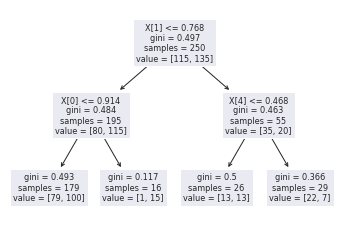

In [288]:
plot_tree(sklearn_dt)

In [318]:
def gini(p):
    return (p)*(1 - (p)) + (1 - p)*(1 - (1-p))

In [321]:
gini(1)

0

In [317]:
clf=sklearn_dt
n_nodes = clf.tree_.node_count
print('n_nodes', n_nodes)
children_left = clf.tree_.children_left
print('children_left', children_left)
children_right = clf.tree_.children_right
print('children_right', children_right)
feature = clf.tree_.feature
print('feature', feature)
threshold = clf.tree_.threshold
print('threshold', threshold)

print('clf.tree_.value', clf.tree_.value)
print('clf.tree_.impurity', clf.tree_.impurity)
print('clf.tree_n_node_samples', clf.tree_.n_node_samples)
print('clf.tree_.weighted_n_node_samples', clf.tree_.weighted_n_node_samples)


node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print('node_depth', node_depth)
print('is_leaves', is_leaves)  

print("The binary tree structure has {n} nodes and has "
      "the following tree structure:\n".format(n=n_nodes))
for i in range(n_nodes):
    if is_leaves[i]:
        print("{space}node={node} is a leaf node.".format(
            space=node_depth[i] * "\t", node=i))
    else:
        print("{space}node={node} is a split node: "
              "go to node {left} if X[:, {feature}] <= {threshold} "
              "else to node {right}.".format(
                  space=node_depth[i] * "\t",
                  node=i,
                  left=children_left[i],
                  feature=feature[i],
                  threshold=threshold[i],
                  right=children_right[i]))

n_nodes 7
children_left [ 1  2 -1 -1  5 -1 -1]
children_right [ 4  3 -1 -1  6 -1 -1]
feature [ 1  0 -2 -2  4 -2 -2]
threshold [ 0.76814133  0.91370732 -2.         -2.          0.46833673 -2.
 -2.        ]
clf.tree_.value [[[115. 135.]]

 [[ 80. 115.]]

 [[ 79. 100.]]

 [[  1.  15.]]

 [[ 35.  20.]]

 [[ 13.  13.]]

 [[ 22.   7.]]]
clf.tree_.impurity [0.4968     0.48389218 0.49311819 0.1171875  0.46280992 0.5
 0.36623068]
clf.tree_n_node_samples [250 195 179  16  55  26  29]
clf.tree_.weighted_n_node_samples [250. 195. 179.  16.  55.  26.  29.]
node_depth [0 1 2 2 1 2 2]
is_leaves [False False  True  True False  True  True]
The binary tree structure has 7 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 1] <= 0.7681413292884827 else to node 4.
	node=1 is a split node: go to node 2 if X[:, 0] <= 0.9137073159217834 else to node 3.
		node=2 is a leaf node.
		node=3 is a leaf node.
	node=4 is a split node: go to node 5 if X[:, 4] <= 0.468336731195449

In [196]:


print(children_left)
print(children_right)

[ 0  1  3  7  8  4  9 10  2  5 11 12  6 13 14]
[ 1  3  7 -1 -1  9 -1 -1  5 11 -1 -1 13 -1 -1]
[ 2  4  8 -1 -1 10 -1 -1  6 12 -1 -1 14 -1 -1]


In [44]:
splits, leaf_classes = get_shaped_parameters_for_decision_tree(dt_pred, config)
print(splits)

tf.Tensor(
[[ 0.         -0.1228093   0.          0.          0.        ]
 [ 0.          0.          0.0474214   0.          0.        ]
 [-0.3681943   0.          0.          0.          0.        ]
 [ 0.13793102  0.          0.          0.          0.        ]
 [ 0.         -0.08740006  0.          0.          0.        ]
 [ 0.          0.          0.          0.23613304  0.        ]
 [ 0.          0.          0.          0.         -0.22431242]
 [ 0.          0.          0.          0.         -0.406705  ]
 [ 0.          0.         -0.17728838  0.          0.        ]
 [ 0.          0.          0.          0.18454176  0.        ]
 [ 0.          0.         -0.46662295  0.          0.        ]
 [ 0.          0.10797334  0.          0.          0.        ]
 [-0.12901036  0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         -0.2911343 ]
 [-0.0644475   0.          0.          0.          0.        ]], shape=(15, 5), dtype=float32)


In [314]:
dt_array_to_sklearn(dt_pred, config)

15
16
31
pre_order_from_level [ 0  1  3  7 15 16  8 17 18  4  9 19 20 10 21 22  2  5 11 23 24 12 25 26
  6 13 27 28 14 29 30]
leaf_indices_pre_order [ 4  5  7  8 11 12 14 15 19 20 22 23 26 27 29 30]
pre_order_from_level [ 0  1  3  7 15 16  8 17 18  4  9 19 20 10 21 22  2  5 11 23 24 12 25 26
  6 13 27 28 14 29 30]
children_left (31,) [ 1  2  3  4 -1 -1  7 -1 -1 10 11 -1 -1 14 -1 -1 17 18 19 -1 -1 22 -1 -1
 25 26 -1 -1 29 -1 -1]
children_right (31,) [16  9  6  5 -1 -1  8 -1 -1 13 12 -1 -1 15 -1 -1 24 21 20 -1 -1 23 -1 -1
 28 27 -1 -1 30 -1 -1]
feature (31,) [ 0  2  0  0 -2 -2  0 -2 -2  0  3 -2 -2  0 -2 -2  1  3  1 -2 -2  1 -2 -2
  0  0 -2 -2  1 -2 -2]
threshold (31,) [ 0.          0.0474214   0.13793102  0.         -2.         -2.
  0.         -2.         -2.          0.          0.18454176 -2.
 -2.          0.         -2.         -2.          0.          0.23613304
  0.10797334 -2.         -2.          0.         -2.         -2.
  0.          0.         -2.         -2.          0.     

[ 1  3  7 15 16  8 17 18  4  9 19 20 10 21 22  2  5 11 23 24 12 25 26  6
 13 27 28 14 29 30]
[ 1  7 16 17  4 19 10 22  5 23 12 26 13 28 29]
[ 3 15  8 18  9 20 21  2 11 24 25  6 27 14 30]


In [279]:
np.where(pre_order_from_level>=2**max_depth-1)[0]

array([ 3,  4,  6,  7, 10, 11, 13, 14])

In [284]:
max_depth = 3
indices_list = [i for i in range(2**(max_depth+1)-1)]
print('indices_list', indices_list)
pre_order_from_level = np.array(level_to_pre(indices_list, 0, []))
print('pre_order_from_level', pre_order_from_level)
leaf_indices_pre_order = np.argwhere(pre_order_from_level>=2**max_depth-1).ravel()
print(leaf_indices_pre_order)
left_indices_pre_order = np.argwhere(pre_order_from_level % 2 != 0).ravel()
right_indices_pre_order = np.argwhere(pre_order_from_level % 2 == 0).ravel()[1:]
print('left_indices_pre_order', left_indices_pre_order)
print('right_indices_pre_order', right_indices_pre_order)

counter = 0
order = []
children_left = []
children_right = []
for i in range(2**(max_depth+1)-1):
    if i in leaf_indices_pre_order:
        order.append(-1)
        if i in left_indices_pre_order:
            children_left.append(-1)
        if i in right_indices_pre_order:
            children_right.append(-1)        
        continue
    else:
        order.append(counter)
        if i in left_indices_pre_order:
            children_left.append(counter)
        if i in right_indices_pre_order:
            children_right.append(counter)           
        counter += 1
order = np.array(order)
children_left = np.array(children_left)
children_right = np.array(children_right)

print('order', order)
print('children_left', children_left)
print('children_right', children_right)


indices_list [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
pre_order_from_level [ 0  1  3  7  8  4  9 10  2  5 11 12  6 13 14]
[ 3  4  6  7 10 11 13 14]
left_indices_pre_order [ 1  2  3  6  9 10 13]
right_indices_pre_order [ 4  5  7  8 11 12 14]
order [ 0  1  2 -1 -1  3 -1 -1  4  5 -1 -1  6 -1 -1]
children_left [ 1  2 -1 -1  5 -1 -1]
children_right [-1  3 -1  4 -1  6 -1]


In [313]:
def dt_array_to_sklearn(vanilla_dt_array, config):
    splits, leaf_classes = get_shaped_parameters_for_decision_tree(vanilla_dt_array, config)
    
    internal_node_num = 2 ** config['function_family']['maximum_depth'] -1    
    leaf_node_num = 2 ** config['function_family']['maximum_depth']    
    n_nodes = internal_node_num + leaf_node_num

    indices_list = [i for i in range(internal_node_num + leaf_node_num)]
    pre_order_from_level = np.array(level_to_pre(indices_list, 0, []))

    level_order_from_pre = np.array(pre_to_level(indices_list))
    children_left = []
    children_right = []
    counter = 0
    for i in pre_order_from_level:#pre_order_from_level:
        left = 2*i+1 
        right = 2*i+2 
        try:
            children_left.append(level_order_from_pre[left])
        except:
            children_left.append(-1)
        try:
            children_right.append(level_order_from_pre[right])
        except:
            children_right.append(-1)            
        
    children_left = np.array(children_left)
    children_right = np.array(children_right)
    
    print('children_left', children_left.shape, children_left)
    print('children_right', children_right.shape, children_right)
    
    indices_list = [i for i in range(internal_node_num+leaf_node_num)]
    new_order = np.array(level_to_pre(indices_list, 0, []))
    
    feature = [np.argmax(split) for split in splits]
    feature.extend([-2 for i in range(leaf_node_num)])
    feature = np.array(feature)[new_order]
    threshold = [np.max(split) for split in splits]
    threshold.extend([-2 for i in range(leaf_node_num)])
    threshold = np.array(threshold)[new_order]
    print('feature', feature.shape, feature)
    print('threshold', threshold.shape, threshold)
    #input_dim = config['data']['number_of_variables']
    #output_dim = config['data']['num_classes'] =


    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    print('node_depth', node_depth)
    print('is_leaves', is_leaves)
    print("The binary tree structure has {n} nodes and has "
          "the following tree structure:\n".format(n=n_nodes))
    for i in range(n_nodes):
        if is_leaves[i]:
            print("{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i))
        else:
            print("{space}node={node} is a split node: "
                  "go to node {left} if X[:, {feature}] <= {threshold} "
                  "else to node {right}.".format(
                      space=node_depth[i] * "\t",
                      node=i,
                      left=children_left[i],
                      feature=feature[i],
                      threshold=threshold[i],
                      right=children_right[i]))    

        
    clf=DecisionTreeClassifier(max_depth=config['function_family']['maximum_depth'])
    clf.tree_.node_count = n_nodes
    clf.tree_.capacity = n_nodes
    clf.tree_.value  #shape [node_count, n_outputs, max_n_classes]; number of samples for each class
    clf.tree_.impurity #
    clf.tree_n_node_samples #number of samples at each node
    clf.tree_.weighted_n_node_samples #same as tree_n_node_samples, but weighted
    clf.tree_.children_left = children_left
    clf.tree_.children_right = children_right
    clf.tree_.feature = feature
    clf.tree_.threshold = threshold

    

In [203]:
def dt_array_to_sklearn(vanilla_dt_array, config):
    splits, leaf_classes = get_shaped_parameters_for_decision_tree(vanilla_dt_array, config)
    
    internal_node_num = 2 ** config['function_family']['maximum_depth'] -1    
    leaf_node_num = 2 ** config['function_family']['maximum_depth']    
    print(internal_node_num)
    print(leaf_node_num)
    n_nodes = internal_node_num + leaf_node_num
    print(n_nodes)
    indices_list = [i for i in range(n_nodes)]
    print('indices_list', indices_list)
    new_order = np.array(level_to_pre(indices_list, 0, []))
    print('new_order', new_order)
    children_left = []
    children_right = []
    for internal_node_num in range(1, internal_node_num+1):
        current_depth = np.ceil(np.log2(internal_node_num+1)).astype(np.int32)
        print('current_depth', current_depth)
        current_depth_initial_node_id = 2 ** current_depth - 1 
        current_node_id_in_depth = internal_node_num-current_depth_initial_node_id
        print('current_node_id_in_depth', current_node_id_in_depth)
        
        subsequent_depth = current_depth+1
        print('subsequent_depth', subsequent_depth)
        internal_node_num_subsequent_depth = 2 ** subsequent_depth - 1 
        print('internal_node_num_subsequent_depth', internal_node_num_subsequent_depth)
        node_index_in_layer = internal_node_num_subsequent_depth + (current_node_id_in_depth*2)
        
        children_left_id = node_index_in_layer 
        children_right_id = node_index_in_layer+1 
        
        
        children_left.append(children_left_id)
        children_right.append(children_right_id)
        
    print(children_left)
    print(children_right)
    children_left.extend([-1 for i in range(leaf_node_num)])
    children_right.extend([-1 for i in range(leaf_node_num)])
    children_left = np.array(children_left)[new_order]
    children_right = np.array(children_right)[new_order]
    print('children_left', children_left)
    print('children_right', children_right)
    feature = [np.argmax(split) for split in splits]
    feature.extend([-2 for i in range(leaf_node_num)])
    feature = np.array(feature)[new_order]
    threshold = [np.max(split) for split in splits]
    threshold.extend([-2 for i in range(leaf_node_num)])
    threshold = np.array(threshold)[new_order]
    print('feature', feature)
    print('threshold', threshold)
    #input_dim = config['data']['number_of_variables']
    #output_dim = config['data']['num_classes'] =


    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    print("The binary tree structure has {n} nodes and has "
          "the following tree structure:\n".format(n=n_nodes))
    for i in range(n_nodes):
        if is_leaves[i]:
            print("{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i))
        else:
            print("{space}node={node} is a split node: "
                  "go to node {left} if X[:, {feature}] <= {threshold} "
                  "else to node {right}.".format(
                      space=node_depth[i] * "\t",
                      node=i,
                      left=children_left[i],
                      feature=feature[i],
                      threshold=threshold[i],
                      right=children_right[i]))    

    #splits = 
    #feature_indices =
    

In [ ]:
for tensor in tf.split(tf.constant([[i*j for i in range(5)] for j in range(15)]), 15):
    print(tf.squeeze(tensor, axis=0))

In [ ]:
tf.split(tf.squeeze(tf.constant([[i*j for i in range(5)] for j in range(15)])), 15)

In [ ]:
tf.not_equal(tf.constant([0,0,1,0]), tf.constant([0,0,0,0]))

In [ ]:
tf.greater(tf.constant([0,0,1,0]), tf.constant([0,0,0,0]))

In [ ]:
tf.equal(tf.constant([0,0,1,0]), 1)

In [ ]:
print('a')

In [ ]:
2**(maximum_depth-(i-1))

In [ ]:
maximum_depth = 4
i=0
split_value =True

zero_identifier= tf.constant([True, False, False, False])
split_complete= tf.constant([True, False, False, False])

split_value = tf.reduce_any(tf.logical_and(zero_identifier, split_complete))
print('split_value', split_value)

split_value_filled = tf.fill([(2**(maximum_depth-(i-1)))], split_value)
print(split_value_filled)
split_value_neg_filled = tf.fill([(2**(maximum_depth-(i-1)))], tf.logical_not(split_value))
print(split_value_filled)
print(tf.keras.backend.flatten(tf.stack([split_value_filled, split_value_neg_filled])))


In [ ]:
tf.cast(tf.constant([True]), tf.float32)

In [ ]:
tf.cast(tf.constant([1]), tf.bool)

In [ ]:
tens = tf.constant([random.randint(0, 100) for i in range(function_representation_length)])
tens

In [ ]:
%autoreload 2
get_shaped_parameters_for_decision_tree(tens, config)

In [ ]:
i = tf.constant([[1,2,3,4],[1,2,3,4]])

In [ ]:
tf.squeeze(tf.constant([[1]]), axis=0)

In [ ]:
dense_tensor = tf.sparse.SparseTensor(indices=indices, values=values, dense_shape=[input_dim])

In [ ]:
function_representation_length

In [ ]:
model.summary()

In [ ]:
acc_target_lambda_list = []
bc_target_lambda_list = []

acc_lambda_decision_list = []
bc_lambda_decision_list = []

acc_target_decision_list = []
bc_target_decision_list = []

decision_function_parameters_list = []
decision_functio_list = []

for lambda_net in tqdm(lambda_net_dataset_test.lambda_net_list):
    
    target_function_parameters = lambda_net.target_function_parameters
    target_function = lambda_net.target_function
    
    X_test_lambda = lambda_net.X_test_lambda
    y_test_lambda = lambda_net.y_test_lambda
    
    network = lambda_net.network
    network_parameters = lambda_net.network_parameters
    
    if config['i_net']['convolution_layers'] != None or config['i_net']['lstm_layers'] != None or (config['i_net']['nas'] and config['nas_type']['convolution_layers'] != 'SEQUENTIAL'):
        network_parameters, network_parameters_flat = restructure_data_cnn_lstm(np.array([network_parameters]), config, subsequences=None)    
      
    decision_function_parameters= model.predict(np.array([network_parameters]))[0]
    decision_function = generate_decision_tree_from_array(decision_function_parameters, config)
    
    decision_function_parameters_list.append(decision_function_parameters)
    decision_functio_list.append(decision_function)
    
    y_test_network = network.predict(X_test_lambda)
    y_test_decision_function = decision_function.predict_proba(X_test_lambda)
    y_test_target_function = target_function.predict_proba(X_test_lambda)  
    
    acc_target_lambda = accuracy_score(np.round(y_test_target_function), np.round(y_test_network))
    bc_target_lambda = log_loss(np.round(y_test_target_function), y_test_network, labels=[0, 1])
    
    acc_lambda_decision = accuracy_score(np.round(y_test_network), np.round(y_test_decision_function))
    bc_lambda_decision = log_loss(np.round(y_test_network), y_test_decision_function, labels=[0, 1])        
    
    acc_target_decision = accuracy_score(np.round(y_test_target_function), np.round(y_test_decision_function))
    bc_target_decision = log_loss(np.round(y_test_target_function), y_test_decision_function, labels=[0, 1])   
    
    
    acc_target_lambda_list.append(acc_target_lambda)
    bc_target_lambda_list.append(bc_target_lambda)

    acc_lambda_decision_list.append(acc_lambda_decision)
    bc_lambda_decision_list.append(bc_lambda_decision)

    acc_target_decision_list.append(acc_target_decision)
    bc_target_decision_list.append(bc_target_decision)
    

acc_target_lambda_array = np.array(acc_target_lambda_list)
bc_target_lambda_array = np.array(bc_target_lambda_list)

acc_lambda_decision_array = np.array(acc_lambda_decision_list)
bc_lambda_decision_array = np.array(bc_lambda_decision_list)

acc_target_decision_array = np.array(acc_target_decision_list)
bc_target_decision_array = np.array(bc_target_decision_list)
    
    
acc_target_lambda = np.mean(acc_target_lambda_array)
bc_target_lambda = np.mean(bc_target_lambda_array[~np.isnan(bc_target_lambda_array)])

acc_lambda_decision = np.mean(acc_lambda_decision_array)
bc_lambda_decision = np.mean(bc_lambda_decision_array[~np.isnan(bc_lambda_decision_array)])

acc_target_decision = np.mean(acc_target_decision_array)
bc_target_decision = np.mean(bc_target_decision_array[~np.isnan(bc_target_decision_array)])


print('Accuracy Target Lambda', acc_target_lambda)
print('Binary Crossentropy Target Lambda', bc_target_lambda)
print('Accuracy Lambda Decision', acc_lambda_decision)
print('Binary Crossentropy Lambda Decision', bc_lambda_decision)
print('Accuracy Target Decision', acc_target_decision)
print('Binary Crossentropy Target Decision', bc_target_decision)


In [ ]:
X_test_lambda

In [ ]:
len(network.get_weights())

In [ ]:
network.get_weights()[0]

In [ ]:
network.get_weights()[1]

In [ ]:
network.get_weights()[2]

In [ ]:
network.get_weights()[3]

In [ ]:
np.round(y_test_network).ravel()[:100]

In [ ]:
np.round(y_test_decision_function).ravel()[:100]

In [ ]:
acc_lambda_decision_array

In [ ]:
# TODO BENCHMARK RANDOM GUESS